In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
import requests, os
import pandas as pd

In [7]:
folder_path = 'data'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

url = "https://github.com/DenisPeskov/2020_acl_diplomacy/raw/master/data/train.jsonl"
response = requests.get(url)

if response.status_code == 200:
    filename = os.path.join(folder_path, os.path.basename(url))
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"File '{filename}' has been downloaded and saved to '{folder_path}'.")
else:
    print(f"Failed to download {url}. Status code: {response.status_code}")

File 'data/train.jsonl' has been downloaded and saved to 'data'.


# New Section

In [8]:
df=pd.read_json('data/train.jsonl', lines=True)
df

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,[Greetings Sultan!\n\nAs your neighbor I would...,"[False, True, False, True, True, True, True, T...","[True, True, True, True, True, True, True, Tru...","[russia, turkey, russia, russia, russia, turke...","[turkey, russia, turkey, turkey, turkey, russi...","[78, 107, 145, 370, 371, 374, 415, 420, 495, 4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1902, 1902, 1902, 1902, 190...","[4, 3, 4, 5, 5, 4, 5, 4, 5, 3, 7]","[1, -1, 1, 1, 1, -1, 1, -1, 2, -2, 7]","[russia, turkey]",10
185,[Greetings My Good Frenchman! \n\nHow are your...,"[True, True, True, True, True, True, True, Fal...","[True, True, False, True, True, True, True, Tr...","[russia, france, russia, russia, france, franc...","[france, russia, france, france, russia, russi...","[7

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                189 non-null    object
 1   sender_labels           189 non-null    object
 2   receiver_labels         189 non-null    object
 3   speakers                189 non-null    object
 4   receivers               189 non-null    object
 5   absolute_message_index  189 non-null    object
 6   relative_message_index  189 non-null    object
 7   seasons                 189 non-null    object
 8   years                   189 non-null    object
 9   game_score              189 non-null    object
 10  game_score_delta        189 non-null    object
 11  players                 189 non-null    object
 12  game_id                 189 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 19.3+ KB


In [10]:
df.loc[0]

messages                  [Germany!\n\nJust the person I want to speak w...
sender_labels             [True, True, True, True, True, True, True, Tru...
receiver_labels           [True, True, True, True, NOANNOTATION, NOANNOT...
speakers                  [italy, germany, italy, germany, italy, italy,...
receivers                 [germany, italy, germany, italy, germany, germ...
absolute_message_index    [74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...
relative_message_index    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
seasons                   [Spring, Spring, Spring, Spring, Spring, Sprin...
years                     [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...
game_score                [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
game_score_delta          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
players                                                    [italy, germany]
game_id                                                                   1
Name: 0, dty

In [11]:
df.loc[0]['messages']

['Germany!\n\nJust the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. \n\nSo...do I suggest it?\n\nI’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.\n\nWhat is your appetite like for unusual and crazy?',
 "You've whet my appetite, Italy. What's the suggestion?",
 '👍',
 "It seems like there are a lot of ways that could go wrong...I don't see why France would see you approaching/taking Munich--while I do nothing about it--and not immediately feel skittish",
 'Yeah, I can’t say I’ve tried it and it works, cause I’ve never tried it or seen it. But how I think it would work is (a) my Spring move looks like an attack on Austria, so it would not be surprising if you did not cover Munich. Then (b) you build two armies, w

**EDA**

**Analyzing text statistics**

In [12]:
import matplotlib as plt
import seaborn as sns

<Axes: >

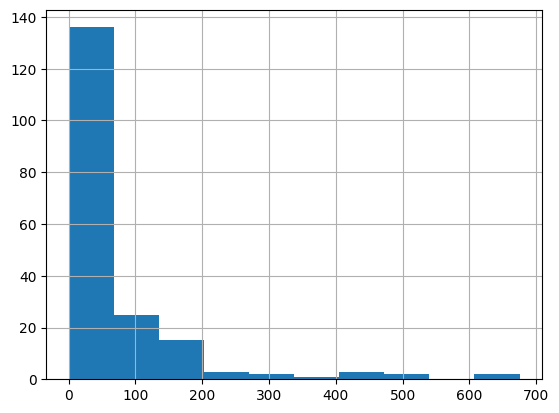

In [41]:
#number of conversations in each messages
df['messages'].str.len().hist()

In [43]:
for i in df['messages'][20]:
  print(len(i))

184
34
57
38
18


In [44]:
len(df['messages'][20])

5

In [47]:
for i,j in df.iterrows():
  print(len(m))

messages                  [Germany!\n\nJust the person I want to speak w...
sender_labels             [True, True, True, True, True, True, True, Tru...
receiver_labels           [True, True, True, True, NOANNOTATION, NOANNOT...
speakers                  [italy, germany, italy, germany, italy, italy,...
receivers                 [germany, italy, germany, italy, germany, germ...
absolute_message_index    [74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...
relative_message_index    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
seasons                   [Spring, Spring, Spring, Spring, Spring, Sprin...
years                     [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...
game_score                [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
game_score_delta          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
players                                                    [italy, germany]
game_id                                                                   1
Name: 0, dty